In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.special import entr
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree, KDTree

scipy.special.entr
elementwise function for computing entropy
$$ f(x)=\left\{
\begin{aligned}
& -xlog(x) x>0 \\
& 0 \quad x=0 \\
& \infty \quad otherwise
\end{aligned}
\right.
$$

In [3]:
def Entropy(data, feature):
    total_cnt = len(data)
    if total_cnt == 0:
        return 0
    else:
        target_cnt = np.array([len(data[data[feature] == 0]), len(data[data[feature] != 0])])
        pk = target_cnt / total_cnt
        vec = entr(pk)
        S = np.sum(vec, axis= 0)
        S /= np.log(2) # 換底公式
        return S

In [4]:
%run ./function.ipynb

In [5]:
PATH = 'C:/Users/NCTUUser2/Desktop/mark/'
FILE = 'TWN_A11_01_day15_with_aggregated_txn_scenario_txn_type_key_營業日.csv'
df = pd.read_csv(PATH + FILE)
df.columns

Index(['alert_id', 'run_date', 'primary_entity_level_code',
       'primary_entity_number', 'scenario_name', 'TO_SAR', 'Acct_No',
       'Cust_No', 'Cust_Key', 'Cust_Segmentation', 'Cust_Typ_Cd', 'Cust_Id_Id',
       'Cust_Id_Typ_Desc', 'Cust_Id_State_Cd', 'Cust_Dt_Of_Birth',
       'Cust_Sts_Desc', 'Street_Postal_Cd', 'Street_Cntry_Cd',
       'Mailing_Postal_Cd', 'Mailing_Cntry_Cd', 'Residence_Cntry_Cd',
       'Citizenship_Cntry_Cd', 'Org_Cntry_Of_Buz_Cd', 'Empl_No', 'Ocup_Code',
       'job_title_code', 'Lst_Cont_Dt', 'Politically_Exposed_Pers_Ind',
       'Non_Prft_Org_Ind', 'Cust_Since_Dt', 'Lst_Susp_Actv_Rpt_Dt',
       'Extnl_Cust_Ind', 'Negative_News_Ind', 'Prim_Br_No', 'Obu_Ind',
       'Riskclass_Cd', 'risk_score', 'last_risk_assessment_date',
       'change_current_ind', 'change_begin_date', 'change_end_date',
       'Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit'],
      dtype='object')

In [6]:
df['TO_SAR'] = df['TO_SAR'].replace(np.nan, 0)
df['TO_SAR'] = df['TO_SAR'].replace('F', 1)
df['TO_SAR'] = df['TO_SAR'].replace('NF', 1)

In [7]:
SAR_type = 'TO_SAR'
train_set, test_set = ReadFile(df, SAR_type)

Verify on time series
shape of data: (86770, 39)
total number of TO_SAR: 446
********************************
time interval in train set:2019-03-04~2020-04-29
TO_SAR in train set: 267
TO_SAR/Total in train set 0.005128599143312653
split dataset to train, test...
********************************
time interval in test set:2020-02-19~2020-12-31
TO_SAR in test set: 179
TO_SAR/Total in test set 0.0051571638479933155
********************************
train data shape:  (52061, 38)
test data shape:  (34709, 38)


In [8]:
train_set = train_set.dropna(subset= ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']).reset_index(drop= True)
test_set = test_set.dropna(subset= ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']).reset_index(drop= True)
print(f'train_set:{train_set.shape}\n' + f'test_set:{test_set.shape}')

train_set:(52060, 38)
test_set:(34709, 38)


In [9]:
SAR = train_set[train_set.TO_SAR!= 0]
Non_SAR = train_set[train_set.TO_SAR== 0]

In [8]:
np.max(SAR['Credit_Amt'])

6840000.0

In [9]:
np.max(Non_SAR['Credit_Amt'])

23214500.0

In [10]:
np.max(SAR['number_of_Credit'])

98.0

In [11]:
np.max(Non_SAR['number_of_Credit'])

852.0

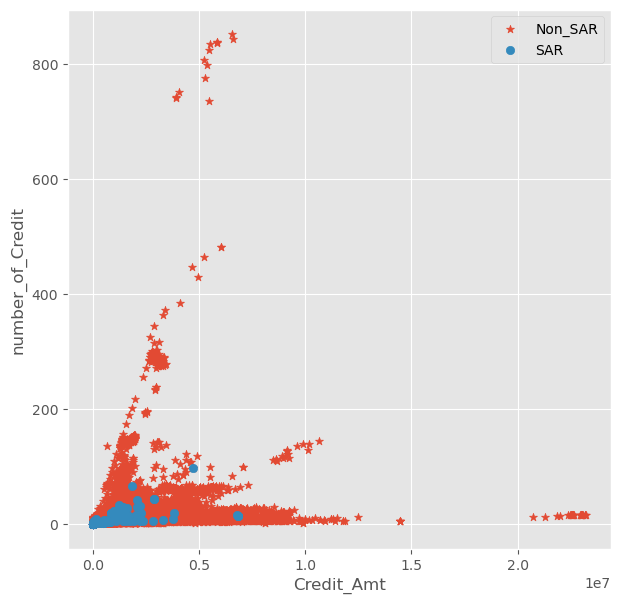

In [10]:
plt.figure(figsize= (7, 7))
plt.style.use('ggplot')
plt.scatter(Non_SAR['Credit_Amt'], Non_SAR['number_of_Credit'], marker= '*', label= 'Non_SAR')
plt.scatter(SAR['Credit_Amt'], SAR['number_of_Credit'], marker= 'o', label= 'SAR')
plt.xlabel('Credit_Amt')
plt.ylabel('number_of_Credit')
plt.legend()
plt.show()

In [11]:
credit_amt_threshold = np.unique(SAR['Credit_Amt']).tolist()
number_of_credit_threshold = np.unique(SAR['number_of_Credit']).tolist()
print(len(credit_amt_threshold), len(number_of_credit_threshold))

86 33


In [14]:
# Hyper parameter settings
RANK = 10
SLICE = 86
beta = 2 # give recall weight=2

In [15]:
LOGIC = "OR"
default_number_of_credit  = 0
default_credit_amt = 0
candidate_rule1 = Search2D(number_of_credit_threshold, credit_amt_threshold, 'number_of_Credit','Credit_Amt',\
                           default_number_of_credit, default_credit_amt, SAR, \
                            Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.3987044048677559 number of max val:  2
Rank: 10, countMax: 2, 100- countZero: 2803
1th, recall: 0.40823970037453183, val1: 0.0, val2: 4000.0
87th, recall: 0.40823970037453183, val1: 1.0, val2: 4000.0
86th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
2th, recall: 0.40074906367041196, val1: 0.0, val2: 11405.0
88th, recall: 0.40074906367041196, val1: 1.0, val2: 11405.0
3th, recall: 0.3970037453183521, val1: 0.0, val2: 16000.0
89th, recall: 0.3970037453183521, val1: 1.0, val2: 16000.0
4th, recall: 0.3895131086142322, val1: 0.0, val2: 20000.0
90th, recall: 0.3895131086142322, val1: 1.0, val2: 20000.0
175th, recall: 0.37453183520599254, val1: 2.0, val2: 16000.0
********************************


In [77]:
thre1 = SAR['Credit_Amt'].min()
thre2 = SAR['number_of_Credit'].min()

idx1 = set(train_set[train_set['Credit_Amt'] >= thre1].index)
idx2 = set(train_set[train_set['number_of_Credit'] >= thre2].index)

idx = list(idx1 & idx2)
new_SAM_1 = train_set.iloc[idx]
new_SAM_0 = train_set.drop(index= new_SAM_1.index)

TP = new_SAM_1[new_SAM_1[SAR_type] != 0].shape[0]
TN = new_SAM_0[new_SAM_0[SAR_type] == 0].shape[0]
FP = new_SAM_1[new_SAM_1[SAR_type] == 0].shape[0]
FN = new_SAM_0[new_SAM_0[SAR_type] != 0].shape[0]

recallRate = TP / (TP + FN)
filterRate = (TN + FN) / (TP + FP + TN + FN)


recall 的定義是 $\frac{TP}{TP+FN}$，應該是找 SAR 中最小的 Credit_Amt 和 number_of_Credit 才對

In [78]:
print(TP, TN, FP, FN)

267 0 51793 0


In [79]:
print('recall:', recallRate, 'filter rate', filterRate)

recall: 1.0 filter rate 0.0


In [64]:
number_of_credit_threshold = []
credit_amt_threshold = []
number_of_debit_threshold = []
debit_amt_threshold = []

FEATURE = ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']
threshold_list = [credit_amt_threshold, number_of_credit_threshold, debit_amt_threshold, number_of_debit_threshold]

for i in range(len(FEATURE)):
    tmp = []
    tmp = list(SAR[FEATURE[i]].values)
    tmp.sort()
    for j in np.linspace(10, 100, 40):
        threshold_list[i].append(np.percentile(tmp, j))
        
    print(threshold_list[i])
    print()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16000.0, 61968.0, 292378.4615384626, 483194.153846153, 668833.6, 806769.23076923, 949076.9230769229, 993144.6153846153, 1051884.6153846155, 1101953.8461538462, 1226061.5384615385, 1300169.2307692308, 1426076.9230769225, 1632338.4615384587, 2057999.9999999993, 2273125.9692307673, 3732153.8461538306, 6840000.0]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 3.0, 5.0, 5.338461538461502, 6.0, 7.0, 8.753846153846155, 11.0, 13.0, 14.16923076923075, 16.0, 18.0, 21.0, 24.72307692307689, 30.72307692307686, 98.0]

[0.0, 1000.0, 15433.846153846156, 62277.000000000065, 100000.0, 314621.2307692305, 725998.076923077, 849976.3076923077, 900000.0, 966376.1538461538, 989913.5076923076, 1000000.0, 1020298.1538461539, 1050000.0, 1050000.0, 1076809.8461538462, 1102014.0, 1126464.0769230768, 1170558.3846153845, 1190105

In [65]:
# Hyper parameter settings
RANK = 10
SLICE = 40
beta = 2 # give recall weight=2

In [66]:
LOGIC = "OR"
default_number_of_credit  = 5
default_credit_amt = 985500
candidate_rule1 = Search2D(number_of_credit_threshold, credit_amt_threshold, 'number_of_Credit','Credit_Amt',\
                           default_number_of_credit, default_credit_amt, SAR, \
                            Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.26262948256054164 number of max val:  1
Rank: 10, countMax: 1, 100- countZero: 147
1069th, recall: 0.23220973782771537, val1: 5.0, val2: 993144.6153846153
1109th, recall: 0.21722846441947566, val1: 5.338461538461502, val2: 993144.6153846153
1149th, recall: 0.21722846441947566, val1: 6.0, val2: 993144.6153846153
1070th, recall: 0.20973782771535582, val1: 5.0, val2: 1051884.6153846155
1189th, recall: 0.20224719101123595, val1: 7.0, val2: 993144.6153846153
1110th, recall: 0.1947565543071161, val1: 5.338461538461502, val2: 1051884.6153846155
1150th, recall: 0.1947565543071161, val1: 6.0, val2: 1051884.6153846155
1071th, recall: 0.18726591760299627, val1: 5.0, val2: 1101953.8461538462
1229th, recall: 0.18352059925093633, val1: 8.753846153846155, val2: 993144.6153846153
1190th, recall: 0.1797752808988764, val1: 7.0, val2: 1051884.6153846155
********************************


In [63]:
LOGIC = "OR"
default_number_of_credit  = 0
default_credit_amt = 0
candidate_rule1 = Search2D(number_of_credit_threshold, credit_amt_threshold, 'number_of_Credit','Credit_Amt',\
                           default_number_of_credit, default_credit_amt, SAR, \
                            Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.39730453715148556 number of max val:  24
Rank: 10, countMax: 24, 100- countZero: 1377
480th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
481th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
482th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
483th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
484th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
485th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
486th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
487th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
488th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
489th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
490th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
491th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
520th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
521th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
522th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
523th, recall: 0.40823970037453183, val1: 1.0, 

### check 微分分子為零的情況

In [12]:
sort_Credit_Amt = np.unique(SAR['Credit_Amt'])
sort_number_of_Credit = np.unique(SAR['number_of_Credit'])

In [19]:
sort_Credit_Amt[-1]

6840000.0

In [36]:
def conditionalEntropy(new_sam_0 , new_sam_1):
    total = len(new_sam_1) + len(new_sam_0)
    return Entropy(new_sam_0) * (len(new_sam_0) / total) \
            + Entropy(new_sam_1, SAR_type) * (len(new_sam_1) / total)

In [37]:
def informationGain(point, x_name, y_name, data):
    
    idx1 = set(data[data[x_name] >= float(point[0])].index)
    idx2 = set(data[data[y_name] >= float(point[1])].index)
    
    #idx3 = set(data[data[y_name] >= float(y_thre)].index)
    
    idx = list(idx1 & idx2)
    new_sam_1 = data.iloc[idx]
    new_sam_0 = data.drop(index= new_sam_1.index)
    #print(len(new_sam_1), len(new_sam_0))
    if len(set(new_sam_1.index) & set(new_sam_0.index)) != 0:
        raise ValueError('new sam 0 and new sam 1 are overlapped')
        
    return -(father_entropy - conditionalEntropy(new_sam_0, new_sam_1))

In [33]:
point = train_set[['Credit_Amt', 'number_of_Credit']]
credit_kdtree = cKDTree(point, leafsize= 100)

In [35]:
def gradientIG(point, x_name, y_name, data):
    _, auxiliary_idx = credit_kdtree.query(point)
    auxiliary = train_set[auxiliary_idx]
    delta = auxiliary - point
    z = informationGain(point, x_name, y_name, data)
    z_delta = [informationGain(np.array([[auxiliary[[0]]], point[[1]]]), x_name, y_name, data), \
        informationGain(np.array([[point[[0]]], auxiliary[[1]]]), x_name, y_name, data)]
    grad = (z_delta - z) / delta